pd.info() : 요약된 df  
pd.isnull().sum() : null인것들 총합  
value_counts() : 해당 컬럼안의 값들이 몇개있는지 - 빈도  
Seriese.name = "" : Seriese 이름을 바꿔줄 수 있음  
df = df1.join(df2) : df1 df2 합쳐서 df  
df.transpose() : 축을 바꿔줌(행 과 열을)  
df.plot(kind ="bar", stacked =True) : bar형태에 stacked = 누  적 그래프  
plt.xticks(rotation=0) : 글자를 가로로 보이게  

### 생각해봐야하는 것들
* 성별 male, female => 0, 1 로 바꿔줘야함 수치로 전환
* Age에 Nan 처리( 모든사람의 평균, 남자여자의 평균 ... )
* Age는 범주형 데이터로 변환 ( 10대, 20대, 30대)
    - Binning : sequentail한 데이터를 category형태로 전환시키는 방식
* Fare에 값 1개가 빠져있었음 => 채워줘야 함
* 큰 값들은 반드시 normalization 처리
* PClass에 대한 처리 필요
* SibSp, Parch에 대한 처리

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Survived,Dead
S,217,427
C,93,75
Q,30,47


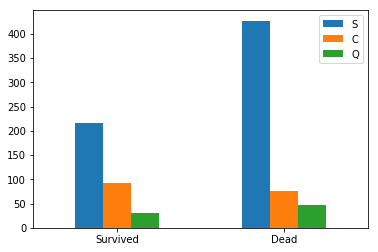

In [176]:
# sibsp 가족수,  parch 같이 탄 가족, fare는 요금, cabin은 객실번호, embarked는 승선한 지역
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
import copy
warnings.filterwarnings(action="ignore")

train = pd.read_csv("./data/titanic/train.csv")
test = pd.read_csv("./data/titanic/test.csv")

display(train.head(5))

def show_chart(param):
    survived = train.loc[(train["Survived"] == 1),param].value_counts()
    # 시리즈의 이름을 바꿔줌
    survived.name = "Survived"
    df1 = pd.DataFrame(survived)
    dead = train.loc[(train["Survived"] == 0),param].value_counts()
    dead.name = "Dead"
    df2 = pd.DataFrame(dead)
    df = df1.join(df2)
    display(df)
    # 축을 바꿔 줌 
    df = df.transpose()
    #stacked 누적차트
    df.plot(kind ="bar", stacked =False)
    # 글자를 옆으로 
    plt.xticks(rotation=0)
    plt.show()
show_chart("Embarked")



In [177]:
# boolean sum
def bool_sum(data1, data2):
    data1_ = np.array(data1, dtype = np.int)
    data2_ = np.array(data2, dtype = np.int)
    and_bool = (data1_ + data2_ == 2)
    return and_bool
# 남자,여자 = 1,0 fuction
def pc_sex(data):
    # 원본은 안바뀌게
    data_ = copy.deepcopy(data)
    data_.loc[(data_["Sex"] == "male"), "Sex"] = 1
    data_.loc[(data_["Sex"] == "female"), "Sex"] = 0
    return data_
# Nan Age를 그냥 평균 Age로 
def pc_age_mean(data):
    data_ = copy.deepcopy(data)
    data_.loc[(data_["Age"].isna()),"Age"] = data_["Age"].mean()
    return data_
# Nan Age를 남 녀 평균으로 나눠서
def pc_age_fm_mean(data):
    data_ = copy.deepcopy(data)
    male_mean = data_.loc[(data_["Sex"] == 1),"Age"].mean()
    female_mean = data_.loc[(data_["Sex"] == 0),"Age"].mean()

    na_age = np.array(data_["Age"].isna(), dtype = np.int32)
    male_p = np.array(data_["Sex"] == 1, dtype = np.int32)
    female_p = np.array(data_["Sex"] == 0, dtype = np.int32)

    data_.loc[((na_age + male_p) == 2), "Age"] = male_mean
    data_.loc[((na_age + female_p) == 2), "Age"] = female_mean
    return data_
# Mr.Mrs.Miss.Master.의 평균으로 NA 채우기 
def pc_age_detail(data):
    data_ = copy.deepcopy(data)
    Mr_bool = data_["Name"].apply(lambda x: True if ("Mr." in x) else False)
    Mr_mean = data_.loc[Mr_bool,"Age"].mean()
    Mrs_bool = data_["Name"].apply(lambda x: True if ("Mrs." in x) else False)
    Mrs_mean = data_.loc[Mrs_bool,"Age"].mean()
    Miss_bool = data_["Name"].apply(lambda x: True if ("Miss." in x) else False)
    Miss_mean = data_.loc[Miss_bool,"Age"].mean()
    Master_bool = data_["Name"].apply(lambda x: True if ("Master." in x) else False)
    Master_mean = data_.loc[Master_bool,"Age"].mean()
    
    Age_insnull = data_["Age"].isnull()

    data_.loc[bool_sum(Mr_bool, Age_insnull), "Age"] = Mr_mean
    data_.loc[bool_sum(Mrs_bool, Age_insnull), "Age"] = Mrs_mean
    data_.loc[bool_sum(Miss_bool, Age_insnull), "Age"] = Miss_mean
    data_.loc[bool_sum(Master_bool, Age_insnull), "Age"] = Master_mean
    return data_

# 나이를 구간으로 8구간으로 나눠서 카테고리로 분류
# def pc_bin(data):
#     n, bins, patches = plt.hist(data["Age"], bins=8)
#     int_bins = []
#     for i in bins:
#         int_bins.append(int(i))

#     age_df = pd.DataFrame(columns=int_bins)
#     data_ = data.sort_values("Age")
#     sum = 0
#     stack_n = []
#     # 일정 구간을 구분 지을 수 있는 누적된 값들의 stack_n list
#     for d in n:
#         sum += d
#         stack_n.append(int(sum))
#     age_values = data_.values
#     d_start = 0
#     for idx,d in enumerate(stack_n):
#         age_values[d_start:d, 5] = idx
#         d_start = d
#     new_data = pd.DataFrame(age_values, columns = data_.columns)
#     return new_data
def pc_bin(data):
    _data = copy.deepcopy(data)
    age_range = [0,10,20,30,40,50,60,70]
    for i in range(len(age_range)):
        if i != (len(age_range)-1):
            bool_index = bool_sum((data["Age"] >= age_range[i]), (data["Age"] < age_range[i+1]))
            _data.loc[bool_index,"Age"] = i
        else :
            bool_index = (data["Age"] >= age_range[i])
            _data.loc[bool_index,"Age"] = i
    return _data
            
# 특정 keyword를 범주형 데이터로 나눔
def pc_dummies(data, keyword):
    data_dum = pd.get_dummies(data[keyword], prefix=keyword)
    data = data.join(data_dum)
    data.drop(keyword, axis = 1, inplace = True)
    return data
# 형제/배우자 혹은 자식/부모가 없이 온 사람들 | 있는 사람들로 이진분류
def pc_family(data):
    data_ = copy.deepcopy(data)
    data_.loc[(data["SibSp"] != 0), "SibSp"] = 1
    data_.loc[(data["Parch"] != 0), "Parch"] = 1
    return data_
# 정규화
def pc_min_max(data, keyword):
    data_ = copy.deepcopy(data)
    scaler = MinMaxScaler()
    data_std = scaler.fit_transform((data[keyword].values).reshape(-1,1))
    data_.loc[:, keyword] = data_std
    return data_


In [178]:
# 성을 0,1로
train_pc = pc_sex(train)
display(train_pc.head(1))
# Nana Embarked를 그냥 S로
train_pc.loc[(train_pc["Embarked"].isna()),"Embarked"] = "S"
# Nan 나이를 그냥 나이 평균
#train_pc = pc_age_mean(train_pc)
# mr, mrs, miss, master로 구분
train_pc = pc_age_detail(train_pc)
# 남녀 평균
train_pc = pc_age_fm_mean(train_pc)

# 빈도수로 카테고리
train_pc = pc_bin(train_pc)
# Age 더미
# train_pc = pc_dummies(train_pc, keyword="Age")
# pclass 더미
train_pc = pc_dummies(train_pc, keyword="Pclass")
# Embraked 더미
train_pc = pc_dummies(train_pc, keyword="Embarked")
display(train_pc.head(1))
# 정규화
train_pc = pc_min_max(train_pc, keyword="Fare")
display(train_pc.head(1))
train_pc.info()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.25,NaN,S


,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",1,2.0,1,0,A/5 21171,7.25,NaN,0,0,1,0,0,1


,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",1,2.0,1,0,A/5 21171,0.014151,NaN,0,0,1,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Pclass_1       891 non-null uint8
Pclass_2       891 non-null uint8
Pclass_3       891 non-null uint8
Embarked_C     891 non-null uint8
Embarked_Q     891 non-null uint8
Embarked_S     891 non-null uint8
dtypes: float64(2), int64(5), object(3), uint8(6)
memory usage: 74.9+ KB


### 공분산(covariane) : 두 확률 변수에 대한 상관관계
- 하지만 단위가 다르면 비교하기 어려움

### 상관계수(Correlation coefficient) : 단위 한계 극복

In [134]:
# 타입을 맞춰줘야 함
#train_pc.loc[:,["Survived","Sex","Age","SibSp","Parch"]] = train_pc.loc[:,["Survived","Sex","Age","SibSp","Parch"]].astype("uint8")
train_pc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Age_0.0        891 non-null uint8
Age_1.0        891 non-null uint8
Age_2.0        891 non-null uint8
Age_3.0        891 non-null uint8
Age_4.0        891 non-null uint8
Age_5.0        891 non-null uint8
Age_6.0        891 non-null uint8
Age_7.0        891 non-null uint8
Pclass_1       891 non-null uint8
Pclass_2       891 non-null uint8
Pclass_3       891 non-null uint8
Embarked_C     891 non-null uint8
Embarked_Q     891 non-null uint8
Embarked_S     891 non-null uint8
dtypes: float64(1), int64(5), object(3), uint8(14)
memory usage: 74.9+ KB


### 피어슨 상관계수

In [113]:
train_pc.corr()

,PassengerId,Survived,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Age_0.0,...,Pclass_6,Pclass_7,Embarked_0,Embarked_1,Embarked_2,Embarked_3,Embarked_4,Embarked_5,Embarked_6,Embarked_7
PassengerId,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.532538,...,0.372307,0.289774,-0.532538,-0.412994,-0.263160,0.230075,0.351073,0.426664,0.372307,0.289774
Survived,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.532538,...,0.372307,0.289774,-0.532538,-0.412994,-0.263160,0.230075,0.351073,0.426664,0.372307,0.289774
Name,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.532538,...,0.372307,0.289774,-0.532538,-0.412994,-0.263160,0.230075,0.351073,0.426664,0.372307,0.289774
Sex,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.532538,...,0.372307,0.289774,-0.532538,-0.412994,-0.263160,0.230075,0.351073,0.426664,0.372307,0.289774
SibSp,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.532538,...,0.372307,0.289774,-0.532538,-0.412994,-0.263160,0.230075,0.351073,0.426664,0.372307,0.289774
Parch,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.532538,...,0.372307,0.289774,-0.532538,-0.412994,-0.263160,0.230075,0.351073,0.426664,0.372307,0.289774
Ticket,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.532538,...,0.372307,0.289774,-0.532538,-0.412994,-0.263160,0.230075,0.351073,0.426664,0.372307,0.289774
Fare,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.532538,...,0.372307,0.289774,-0.532538,-0.412994,-0.263160,0.230075,0.351073,0.426664,0.372307,0.289774
Cabin,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.532538,...,0.372307,0.289774,-0.532538,-0.412994,-0.263160,0.230075,0.351073,0.426664,0.372307,0.289774
Age_0.0,-0.532538,-0.532538,-0.532538,-0.532538,-0.532538,-0.532538,-0.532538,-0.532538,-0.532538,1.000000,...,-0.041751,-0.025169,1.000000,-0.101697,-0.179588,-0.203546,-0.094222,-0.067492,-0.041751,-0.025169


In [179]:
# 성을 0,1로
test_d = pc_sex(test)
# mr, mrs, miss, master로 구분
test_d = pc_age_detail(test_d)
# 남녀 평균
test_d = pc_age_fm_mean(test_d)
# 빈도수로 카테고리
test_d = pc_bin(test_d)

# 비어있는 Fare를 그냥 연관성이 제일큰 Pclasㄴ들의 평균으로 채움
fare_mean = test_d.loc[test_d["Pclass"] == 3, "Fare"].mean()
test_d.loc[test_d["Fare"].isna(), "Fare"] = fare_mean
# Age 더미
# test_d = pc_dummies(test_d, keyword="Age")
# pclass 더미
test_d = pc_dummies(test_d, keyword="Pclass")
# Embraked 더미
test_d = pc_dummies(test_d, keyword="Embarked")
# 정규화
test_d = pc_min_max(test_d, keyword="Fare")

test_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 15 columns):
PassengerId    418 non-null int64
Name           418 non-null object
Sex            418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          91 non-null object
Pclass_1       418 non-null uint8
Pclass_2       418 non-null uint8
Pclass_3       418 non-null uint8
Embarked_C     418 non-null uint8
Embarked_Q     418 non-null uint8
Embarked_S     418 non-null uint8
dtypes: float64(2), int64(4), object(3), uint8(6)
memory usage: 31.9+ KB


In [180]:
# 필요없는 future 삭제
train_pc.drop(["Name", "Ticket","Cabin"], axis=1, inplace =True)
test_d.drop(["Name", "Ticket","Cabin"], axis=1, inplace =True)

In [181]:
test_d.sort_values(by = "PassengerId", inplace = True)
train_pc.sort_values(by = "PassengerId", inplace = True)
display(train_pc.head(1))
display(test_d.head(1))

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,1,2.0,1,0,0.014151,0,0,1,0,0,1


,PassengerId,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,892,1,3.0,0,0,0.015282,0,0,1,0,1,0


In [182]:
print(train_pc.info())
print(test_d.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Pclass_1       891 non-null uint8
Pclass_2       891 non-null uint8
Pclass_3       891 non-null uint8
Embarked_C     891 non-null uint8
Embarked_Q     891 non-null uint8
Embarked_S     891 non-null uint8
dtypes: float64(2), int64(5), uint8(6)
memory usage: 60.9 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Sex            418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Pclass_1       418 non-null uint8
Pclass_2       418 non-null uint8
Pc

In [186]:
import tensorflow as tf

tf.reset_default_graph()

x_train_data = train_pc.drop(["PassengerId","Survived"], axis=1)
y_train_data = train_pc["Survived"].values.reshape(-1,1)
x_test_data = test_d.drop(["PassengerId"], axis=1)
print("x_train_data.shape : {}, y_train_data.shape : {}".format(x_train_data.shape, y_train_data.shape))

X = tf.placeholder(shape = [None, 11], dtype = tf.float32)
Y = tf.placeholder(shape = [None, 1], dtype = tf.float32)
drop_prob = tf.placeholder(dtype = tf.float32)

W1 = tf.get_variable("weight1", shape = [11,256], initializer=tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
b1 = tf.Variable(tf.random_normal([256]), dtype = tf.float32)
_h_layer1 = tf.nn.relu(tf.matmul(X,W1)+b1)
h_layer1 = tf.nn.dropout(_h_layer1, keep_prob=drop_prob)

W2 = tf.get_variable("weight2", shape = [256,512], initializer=tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
b2 = tf.Variable(tf.random_normal([512]), dtype = tf.float32)
_h_layer2 = tf.nn.relu(tf.matmul(h_layer1,W2)+b2)
h_layer2 = tf.nn.dropout(_h_layer2, keep_prob=drop_prob)

W3 = tf.get_variable("weight3", shape = [512,256], initializer=tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
b3 = tf.Variable(tf.random_normal([256]), dtype = tf.float32)
_h_layer3 = tf.nn.relu(tf.matmul(h_layer2,W3)+b3)
h_layer3 = tf.nn.dropout(_h_layer3, keep_prob=drop_prob)

##
W4 = tf.get_variable("weight4", shape = [256,128], initializer=tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
b4 = tf.Variable(tf.random_normal([128]), dtype = tf.float32)
_h_layer4 = tf.nn.relu(tf.matmul(h_layer3,W4)+b4)
h_layer4 = tf.nn.dropout(_h_layer4, keep_prob=drop_prob)


W5 = tf.get_variable("weight5", shape = [128,1], initializer=tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
b5 = tf.Variable(tf.random_normal([1]), dtype = tf.float32)
logit = tf.matmul(h_layer4, W5) + b5
H = tf.sigmoid(logit)

cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logit, labels = Y))
optimzer = tf.train.GradientDescentOptimizer(learning_rate=0.05)
train = optimzer.minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# train_epoch = 30
# batch_size = 100
# for step in range(train_epoch):
#     num_of_iter = int(x_train_data.shape[0]/batch_size)
#     for i in range(num_of_iter):
#         batch_x, batch_y = 
for step in range(50000):
    _, cost_val = sess.run([train,cost], feed_dict={X:x_train_data, Y:y_train_data, drop_prob : 0.7})
    if step % 5000 == 0:
        print("cost_val :{}".format(cost_val))
predict = tf.cast(H>0.5, dtype=tf.float32)
correct =  tf.equal(predict, Y)
accuracy = tf.reduce_mean(tf.cast(correct,dtype =tf.float32))
print("accuracy : {}".format(sess.run(accuracy, feed_dict={X:x_train_data,Y:y_train_data, drop_prob:1.0})))




x_train_data.shape : (891, 11), y_train_data.shape : (891, 1)
cost_val :1.0076613426208496
cost_val :0.41645848751068115
cost_val :0.4007899761199951
cost_val :0.36808738112449646
cost_val :0.3723597526550293
cost_val :0.3623228371143341
cost_val :0.3476525843143463
cost_val :0.33883926272392273
cost_val :0.34279003739356995
cost_val :0.32591724395751953
accuracy : 0.8709315657615662


In [187]:
predict_y = tf.cast(H > 0.5, dtype = tf.int32)
desire_y = sess.run(predict_y, feed_dict = {X:x_test_data, drop_prob:1.0})

In [188]:
# test_d["PassengerId"].values
df_predict = pd.DataFrame(test_d["PassengerId"].values)
df_predict = df_predict.rename(columns = {0:"PassengerId"})
df_predict["Survived"] = desire_y
df_predict.to_csv("./data/titanic/predict.csv", sep = ',',index=False)